# Assessing performance across experiments

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import math
import os
import scipy.stats as stats
from tabulate import tabulate
import itertools
from scipy.stats import norm, ttest_ind, f_oneway, t, shapiro, levene, mannwhitneyu, wilcoxon, kruskal
import matplotlib.ticker as ticker


In [58]:
n_list = [1, 2, 3]
blocks = 50
current_dir = os.getcwd()

In [59]:
def compute_summary_stats(all_trials, exp_name, n_list, blocks):
    summary_stats = {}
    raw_data = {}
    for n in n_list:
        hit_rate, false_alarm_rate, accuracy, response_time, d_prime = [], [], [], [], []
        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            # Compute the hit rate, false alarm rate, and response time
            hits, false_alarms, total_targets, total_lures, total_rt = 0, 0, 0, 0, 0
            for trial in trials:
                if trial['target'] == 'm':
                    total_targets += 1
                    if trial['correct']:
                        hits += 1
                        total_rt += trial['rt']
                    elif trial['correct'] == '':
                        raise ValueError("Missing data in " + exp_name + " " + str(n) + "-back task, block " + str(b) + '.')
                else:
                    total_lures += 1
                    if trial['correct'] == '':
                        raise ValueError("Missing data in " + exp_name + " " + str(n) + "-back task, block " + str(b) + '.')
                    elif not trial['correct']:
                        false_alarms += 1

            hit_rate.append((hits / total_targets) * 100)
            false_alarm_rate.append((false_alarms / total_lures) * 100)
            accuracy.append(((hits + total_lures - false_alarms) / (total_targets + total_lures)) * 100)
            response_time.append(total_rt / hits if hits > 0 else np.nan)

            # Compute d prime
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99)
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99)
            d_prime.append(np.abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted)))

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "d_prime": d_prime
        }
            
        summary_stats[n] = {
            "hit_rate": {"mean": np.mean(hit_rate),  "stderr": np.std(hit_rate) / math.sqrt(blocks)},
            "false_alarm_rate": {"mean": np.mean(false_alarm_rate), "stderr": np.std(false_alarm_rate) / math.sqrt(blocks)},
            "accuracy": {"mean": np.mean(accuracy), "stderr": np.std(accuracy) / math.sqrt(blocks)},
            "d_prime": {"mean": np.mean(d_prime), "stderr": np.std(d_prime) / math.sqrt(blocks)}
        }
    return summary_stats, raw_data



In [60]:
# we use the non-parametric test to compare the performance of different n-back tasks
def nonparametric_test(raw_data, n_list):
    metrics = ["d_prime"]
    U_list = []
    corrected_p_list = []
    r_list = []
    for metric in metrics:
        # print(f"Kruskal-Wallis test for {metric}:")

        # Prepare the data for Kruskal-Wallis test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform Kruskal-Wallis test
        H, p = kruskal(*data)

        # Calculate degrees of freedom
        df = len(n_list) - 1

        # Calculate the total number of observations
        N = len(raw_data[n_list[0]][metric]) * len(n_list)
        
        # Calculate epsilon squared (ε²):ε² = (H - k + 1) / (N - k), where H is the Kruskal-Wallis H statistic, k is the number of groups (in your case, len(n_list)), N is the total number of observations across all groups
        epsilon_squared = (H - len(n_list) + 1) / (N - len(n_list))

        # print(f"  H({df}) = {H:.4f}, p = {p:.4f}, epsilon squared = {epsilon_squared:.4f}")

        # Perform post-hoc Mann-Whitney U test
        # print("  Post-hoc Mann-Whitney U test:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # Mann-Whitney U test
            U, p_value = mannwhitneyu(data1, data2)

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate the effect size using the rank-biserial correlation (r): r = 1 – (2U)/ (n1 * n2)
            r = 1 - (2 * U) / (len(data1) * len(data2))
            U_list.append(U)
            corrected_p_list.append(corrected_p)
            r_list.append(r)
            # print(f"    {n1}-back vs {n2}-back: U = {U:.4f}, p = {corrected_p:.4f}, rank-biserial correlation(r) = {r:.4f}")
        # return (H, p, epsilon_squared) and (U_list, corrected_p_list, r_list)
        return (H, p, epsilon_squared), (U_list, corrected_p_list, r_list)


In [61]:
# define a function to test for each n in n_list if the d' is significantly larger than 1
def test_dprime(raw_data,n_list):
    stats_list = []
    p_list = []
    r_list = []
    data = [np.array(raw_data[n]["d_prime"]) for n in n_list]
    for n in range(len(n_list)):
        # Subtract the hypothesized median (1 in this case) from the data
        differences = data[n] - 1
        # Wilcoxon Signed-Rank Test
        statistic, p_value = stats.wilcoxon(differences, alternative="greater")
        # Compute the sum of positive ranks and the sum of negative ranks
        positive_ranks = np.sum(np.where(differences > 0, stats.rankdata(np.abs(differences)), 0))
        negative_ranks = np.sum(np.where(differences < 0, stats.rankdata(np.abs(differences)), 0))
        # Calculate the rank-biserial correlation
        rank_biserial = (positive_ranks - negative_ranks) / (positive_ranks + negative_ranks)
        stats_list.append(statistic)
        p_list.append(p_value)
        r_list.append(rank_biserial)
    return (stats_list, p_list, r_list)

In [62]:
# plot the distribution of the data
def plot_distribution(raw_data, n_list):
    metrics = ["d_prime"]

    for metric in metrics:
        print(f"Distribution plot for {metric}:")

        # Prepare the data for distribution plot
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform distribution plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i, ax in enumerate(axes.flat):
            sns.histplot(data[i], ax=ax, color="blue", bins=20, kde=True, stat="count")
            # sns.displot(data[i], ax=ax, kde=True, color="black")
            # sns.distplot(data[i], ax=ax, color="blue")
            ax.set_title(f"{n_list[i]}-back", fontsize=14, fontweight='bold')
            ax.set_xlabel(metric.replace("_", " ").capitalize())
            ax.set_ylabel("Count")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # remove the grid lines
            ax.grid(False)
            # set the weight  and color of axes lines
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            # show tick lines on the left and bottom axes
            ax.tick_params(axis='both', which='both', bottom=True, left=True)
            

        # layout setting: adjust the space between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()
        return fig
    return fig


In [63]:
# load data (all_trials_verbal.json,all_trials_verbal_noise.json, all_trials_verbal_think_by_step.json, all_trials_verbal_feedback.json) from multiple verbal task experiments
def load_data_from_verbal_experiments():
    # load data from all_trials_verbal.json
    with open(os.path.join(current_dir, "results", "all_trials_verbal.json"), "r") as f:
        trials_verbal = json.load(f)

    # load data from all_trials_verbal_noise.json
    with open(os.path.join(current_dir, "results", "all_trials_verbal_noise.json"), "r") as f:
        trials_verbal_noise = json.load(f)

    # load data from all_trials_verbal_think_by_step.json
    with open(os.path.join(current_dir, "results", "all_trials_verbal_think_by_step.json"), "r") as f:
        trials_verbal_think_by_step = json.load(f)

    # load data from all_trials_verbal_feedback.json
    with open(os.path.join(current_dir, "results", "all_trials_verbal_feedback.json"), "r") as f:
        trials_verbal_feedback = json.load(f)

    return trials_verbal, trials_verbal_noise, trials_verbal_think_by_step, trials_verbal_feedback

trials_verbal, trials_verbal_noise, trials_verbal_think_by_step, trials_verbal_feedback = load_data_from_verbal_experiments()

# calculate the summary statistics (hit rate, false alarm rate, accuracy, d prime) for all the verbal experiments
summary_stats_verbal, raw_data_verbal = compute_summary_stats(trials_verbal, 'verbal', n_list, blocks)
summary_stats_verbal_noise, raw_data_verbal_noise = compute_summary_stats(trials_verbal_noise, 'verbal_noise', n_list, blocks)
summary_stats_verbal_think_by_step, raw_data_verbal_think_by_step = compute_summary_stats(trials_verbal_think_by_step, 'verbal_think_by_step', n_list, blocks)
summary_stats_verbal_feedback, raw_data_verbal_feedback = compute_summary_stats(trials_verbal_feedback, 'verbal_feedback', n_list, blocks)

    


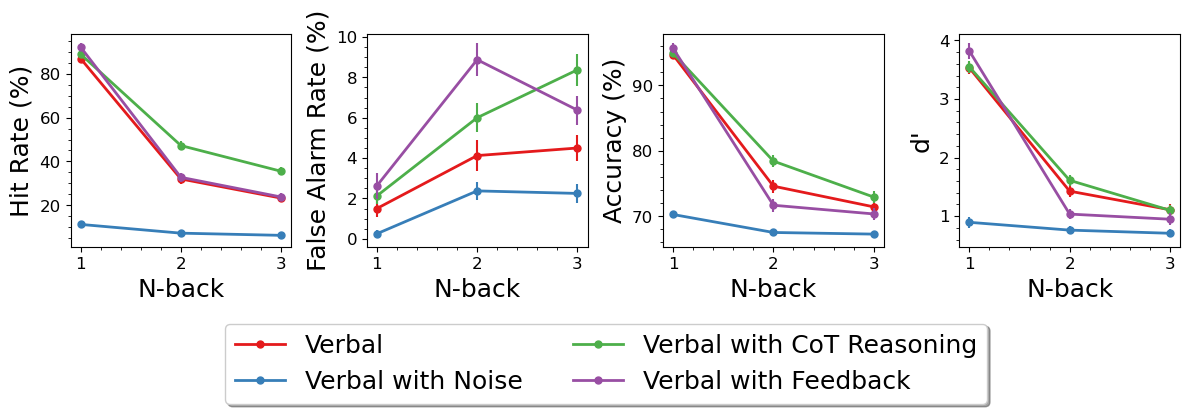

In [64]:
def plot_performance(summary_stats_verbal, summary_stats_verbal_noise, summary_stats_verbal_think_by_step, summary_stats_verbal_feedback, n_list):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
    axes = axes.flatten()
    palette = sns.color_palette("Set1", 4)
    line_styles = ['-', '-', '-', '-']

    for i, (measure, ylabel) in enumerate(zip(["hit_rate", "false_alarm_rate", "accuracy", "d_prime"],
                                              ["Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "d'"])):
        ax = axes[i]
        for j, (summary_stats, label) in enumerate(zip([summary_stats_verbal, summary_stats_verbal_noise, summary_stats_verbal_think_by_step, summary_stats_verbal_feedback],
                                        ["Verbal", "Verbal with Noise", "Verbal with CoT Reasoning", "Verbal with Feedback"])):
            ax.plot(n_list, [summary_stats[n][measure]["mean"] for n in n_list], label=label,  color=palette[j], linestyle=line_styles[j], linewidth=2,marker='o', markersize=5)
            ax.errorbar(n_list, [summary_stats[n][measure]["mean"] for n in n_list],
                        yerr=[summary_stats[n][measure]["stderr"] for n in n_list], fmt='none',  ecolor=palette[j], alpha=1)

        ax.set_ylabel(ylabel, fontsize=18)
        ax.grid(False)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(axis='both', which='both', labelsize=12)
        ax.set_xlabel("N-back", fontsize=18)

    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.3), fancybox=True, shadow=True, ncol=2, fontsize=18)
    plt.show()
    return fig

fig = plot_performance(summary_stats_verbal, summary_stats_verbal_noise, summary_stats_verbal_think_by_step, summary_stats_verbal_feedback, n_list)

# save figure
# fig.savefig(os.path.join("figures", "performance_on_verbal_n_back_tasks.pdf"), format="pdf",dpi=300, bbox_inches='tight')


In [65]:
# for each verbal task, perform non-parametric statistical tests (Kruskal-Wallis H test and post-hoc U test) on the d_prime scores across different N-back levels
# and define a function to create a latex table for the H tests
# and define a function to create a latex table for the post hoc U tests
verbal_H, verbal_U = nonparametric_test(raw_data_verbal, n_list)
verbal_noise_H, verbal_noise_U = nonparametric_test(raw_data_verbal_noise, n_list)
verbal_think_by_step_H, verbal_think_by_step_U = nonparametric_test(raw_data_verbal_think_by_step, n_list)
verbal_feedback_H, verbal_feedback_U = nonparametric_test(raw_data_verbal_feedback, n_list)

task_names = ["Verbal", "Verbal with Noise", "Verbal with CoT Reasoning", "Verbal with Feedback"]
H_results = [verbal_H, verbal_noise_H, verbal_think_by_step_H, verbal_feedback_H]
# put the H test results of all the verbal tasks together and create a latex table
def create_table_H(results, task_names):
    headers = ["Task", "H", "p", "$\epsilon^2$"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        row = [task_name]
        for i,header in enumerate(headers[1:]):
            row.append(result[i])
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_H(H_results, task_names)

# we need to define another column for the U test names within each task
test_groups = ["1-back vs 2-back","1-back vs 3-back","2-back vs 3-back"]
U_results = [verbal_U, verbal_noise_U, verbal_think_by_step_U, verbal_feedback_U]
# each U result is a tuple of 3 lists, each list contains the U test results for one of the test groups
# put the U test results of all the verbal tasks together and create a latex table
# each row should be the U test results (including "U","Bonferroni-corrected p","rank-biserial correlation(r)") for one of the test groups
def create_table_U(results, task_names,test_groups):
    headers = ["Task", "Test","U","Bonferroni-corrected p","rank-biserial correlation(r)"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_U(U_results, task_names,test_groups)
    




\begin{tabular}{lrrr}
\hline
 Task                      &        H &           p &   $\epsilon^2$ \\
\hline
 Verbal                    & 97.5376  & 6.60666e-22 &      0.649916  \\
 Verbal with Noise         &  3.91569 & 0.141162    &      0.0130319 \\
 Verbal with CoT Reasoning & 99.4143  & 2.58493e-22 &      0.662683  \\
 Verbal with Feedback      & 94.9077  & 2.46072e-21 &      0.632025  \\
\hline
\end{tabular}
\begin{tabular}{llrrr}
\hline
 Task                      & Test             &      U &   Bonferroni-corrected p &   rank-biserial correlation(r) \\
\hline
 Verbal                    & 1-back vs 2-back & 2451.5 &              2.66392e-16 &                        -0.9612 \\
 Verbal                    & 1-back vs 3-back & 2487   &              3.30459e-17 &                        -0.9896 \\
 Verbal                    & 2-back vs 3-back & 1566   &              0.0849936   &                        -0.2528 \\
 Verbal with Noise         & 1-back vs 2-back & 1444.5 &              0.47

In [66]:
# create dprime Wilcoxon test table

verbal_dprime = test_dprime(raw_data_verbal, n_list)
verbal_noise_dprime = test_dprime(raw_data_verbal_noise, n_list)
verbal_think_by_step_dprime = test_dprime(raw_data_verbal_think_by_step, n_list)
verbal_feedback_dprime = test_dprime(raw_data_verbal_feedback, n_list)

task_names = ["Verbal", "Verbal with Noise", "Verbal with CoT Reasoning", "Verbal with Feedback"]
test_groups = ["1-back","2-back","3-back"]
dprime_results = [verbal_dprime, verbal_noise_dprime, verbal_think_by_step_dprime, verbal_feedback_dprime]

def create_table_dprime(results, task_names,test_groups):
    headers = ["Task","n-back","T","p","r"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_dprime(dprime_results, task_names,test_groups)
    




\begin{tabular}{llrrr}
\hline
 Task                      & n-back   &    T &           p &          r \\
\hline
 Verbal                    & 1-back   & 1275 & 8.88178e-16 &  1         \\
 Verbal                    & 2-back   & 1046 & 1.9091e-05  &  0.640784  \\
 Verbal                    & 3-back   &  811 & 0.0475667   &  0.272157  \\
 Verbal with Noise         & 1-back   &  620 & 0.568367    & -0.027451  \\
 Verbal with Noise         & 2-back   &  299 & 0.999608    & -0.53098   \\
 Verbal with Noise         & 3-back   &  231 & 0.99998     & -0.637647  \\
 Verbal with CoT Reasoning & 1-back   & 1275 & 8.88178e-16 &  1         \\
 Verbal with CoT Reasoning & 2-back   & 1160 & 1.547e-08   &  0.819608  \\
 Verbal with CoT Reasoning & 3-back   &  719 & 0.218784    &  0.127843  \\
 Verbal with Feedback      & 1-back   & 1275 & 8.88178e-16 &  1         \\
 Verbal with Feedback      & 2-back   &  709 & 0.248194    &  0.112157  \\
 Verbal with Feedback      & 3-back   &  588 & 0.683913    & -0

Distribution plot for d_prime:


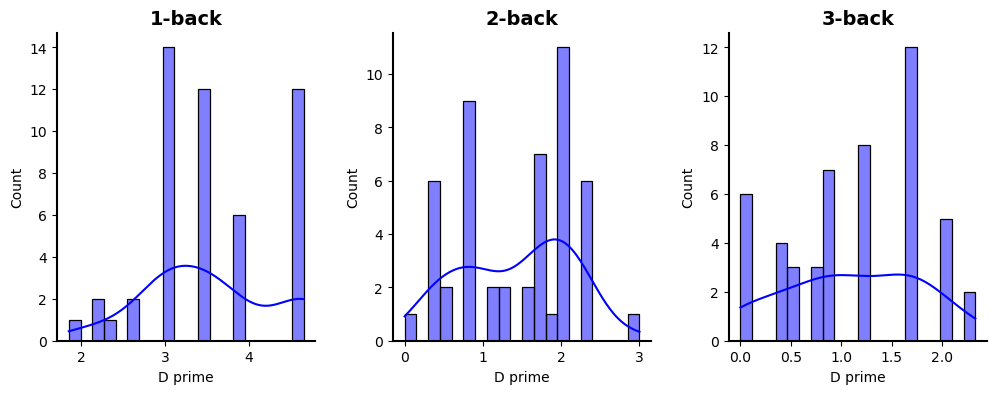

Distribution plot for d_prime:


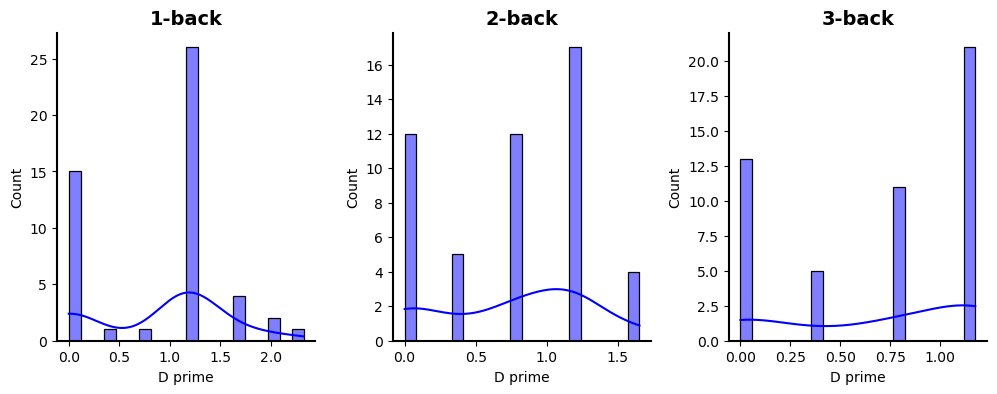

Distribution plot for d_prime:


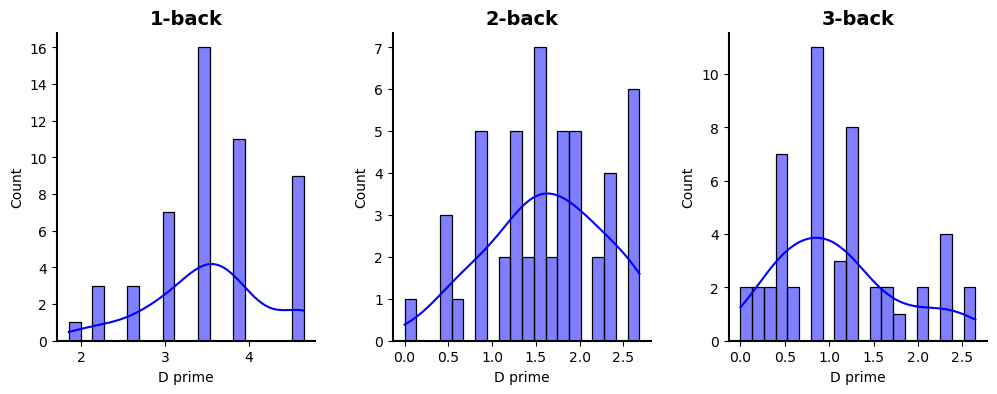

Distribution plot for d_prime:


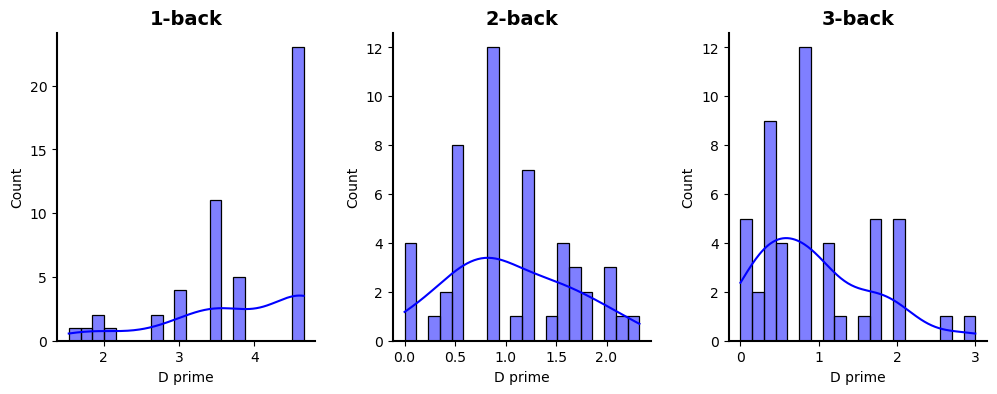

In [67]:
# plot the distribution of the d_prime scores for each N-back level
fig_verbal = plot_distribution(raw_data_verbal, n_list)
fig_verbal_noise = plot_distribution(raw_data_verbal_noise, n_list)
fig_verbal_think_by_step = plot_distribution(raw_data_verbal_think_by_step, n_list)
fig_verbal_feedback = plot_distribution(raw_data_verbal_feedback, n_list)
# save figures to pdf
fig_verbal.savefig(os.path.join("figures", "distribution_of_d_prime_scores_for_verbal_n_back_tasks.pdf"), format="pdf",dpi=300, bbox_inches='tight')
fig_verbal_noise.savefig(os.path.join("figures", "distribution_of_d_prime_scores_for_verbal_noise_n_back_tasks.pdf"), format="pdf",dpi=300, bbox_inches='tight')
fig_verbal_think_by_step.savefig(os.path.join("figures", "distribution_of_d_prime_scores_for_verbal_think_by_step_n_back_tasks.pdf"), format="pdf",dpi=300, bbox_inches='tight')
fig_verbal_feedback.savefig(os.path.join("figures", "distribution_of_d_prime_scores_for_verbal_feedback_n_back_tasks.pdf"), format="pdf",dpi=300, bbox_inches='tight')


In [ ]:
# Prepare data
experiments = ["Verbal", "Verbal Noise", "Verbal Think By Step", "Verbal Feedback"]
measures = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]
data = []

for n in n_list:
    for exp, summary_stats in zip(experiments, [summary_stats_verbal, summary_stats_verbal_noise, summary_stats_verbal_think_by_step, summary_stats_verbal_feedback]):
        data.append([n, exp] + [summary_stats[n][measure]["mean"] for measure in measures])

df = pd.DataFrame(data, columns=["N-back", "Experiment"] + measures)

# Radar Chart
def plot_radar_chart(df, n):
    # Number of variables
    num_vars = len(measures)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialize plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

    # Set axis labels and ticks
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(measures)
    ax.set_yticklabels([])
    
    # Plot each experiment
    for exp, color in zip(experiments, sns.color_palette("deep", 4)):
        values = df.loc[(df["Experiment"] == exp) & (df["N-back"] == n), measures].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, label=exp, color=color)
        ax.fill(angles, values, color=color, alpha=0.25)

    # Add legend and title
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title(f"{n}-back Radar Chart", size=16, color="black", y=1.1)

for n in n_list:
    plot_radar_chart(df, n)

# Parallel Coordinates Plot
def plot_parallel_coordinates(df):
    measures = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]
    fig, ax = plt.subplots(figsize=(10, 6))
    pd.plotting.parallel_coordinates(df, class_column="Experiment", cols=["N-back"] + measures, ax=ax, color=sns.color_palette("deep", 4))
    ax.legend(fontsize=12)
    plt.xticks(range(1, 1 + len(measures)), measures, rotation=-45, ha='left', fontsize=12)
    ax.set_ylabel("Performance Measures", fontsize=14)
    ax.set_xlabel("Measures", fontsize=14)
    ax.set_title("Parallel Coordinates Plot", fontsize=16)
    plt.grid(False)
    plt.show()

plot_parallel_coordinates(df)

def plot_heatmap(df, measure):
    # Pivot the DataFrame to create a matrix format with experiments as columns and n-back levels as rows
    heatmap_data = df.pivot_table(index="N-back", columns="Experiment", values=measure)

    # Create a heatmap using seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': measure}, ax=ax)

    # Customize the appearance of the heatmap
    ax.set_title(f"Heatmap for {measure}", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xlabel("Experiment", fontsize=14)
    ax.set_ylabel("N-back", fontsize=14)
    plt.show()

# Create a heatmap for each performance measure
for measure in ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]:
    plot_heatmap(df, measure)

In [69]:

# load data from multiple experiments
def load_data_from_experiments(exps):
    # load data from every element in exps
    all_exps = {}
    for exp in exps:
        file_path = os.path.join(current_dir, "results", exp)
        with open(file_path, "r") as f:
            print("loading data from "+exp)
            # path relative to the 'results' folder in the current directory + exp
            all_exps[exp] = json.load(f)
    return all_exps


loading data from all_trials_spatial_3*3.json
loading data from all_trials_spatial_with_noise.json
loading data from all_trials_spatial_think_by_step.json
loading data from all_trials_spatial_feedback.json


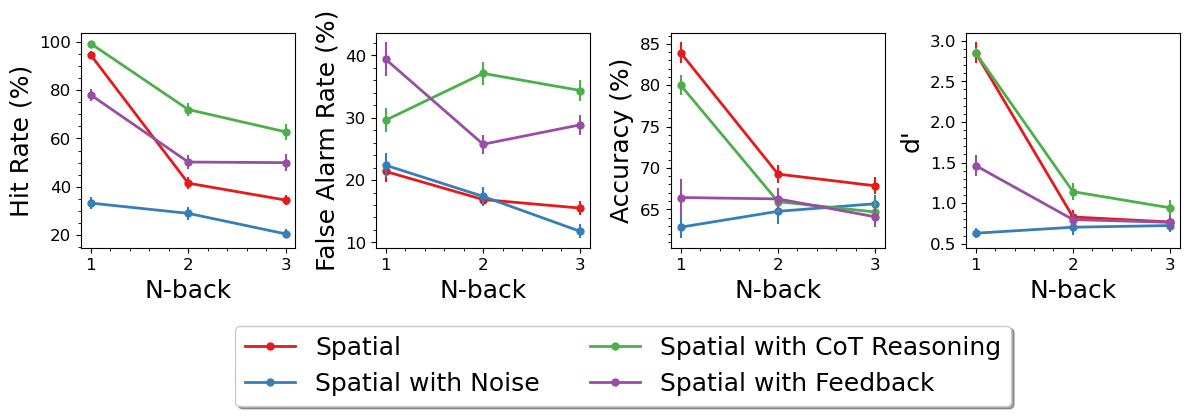

In [70]:
exps = ['all_trials_spatial_3*3.json', 'all_trials_spatial_with_noise.json', 'all_trials_spatial_think_by_step.json', 'all_trials_spatial_feedback.json']
spatial_exps = load_data_from_experiments(exps)

# compute summary statistics for the spatial task experiments
summary_stats_spatial_exps = {}
raw_data_spatial_exps = {}
for exp_name in exps:
    summary_stats_spatial_exps[exp_name],raw_data_spatial_exps[exp_name] = compute_summary_stats(spatial_exps[exp_name], exp_name, n_list, blocks)

# plot performance for the spatial task experiments
def plot_performance_spatial(summary_stats_spatial_exps):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
    axes = axes.flatten()
    palette = sns.color_palette("Set1", 4)
    line_styles = ['-', '-', '-', '-']

    for i, (measure, ylabel) in enumerate(zip(["hit_rate", "false_alarm_rate", "accuracy", "d_prime"],
                                              ["Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "d'"])):
        ax = axes[i]
        for j, (summary_stats, label) in enumerate(zip([summary_stats_spatial_exps[exp] for exp in exps],
                                        ["Spatial", "Spatial with Noise", "Spatial with CoT Reasoning", "Spatial with Feedback"])):
            ax.plot(n_list, [summary_stats[n][measure]["mean"] for n in n_list], label=label,  color=palette[j], linestyle=line_styles[j], linewidth=2,marker='o', markersize=5)
            ax.errorbar(n_list, [summary_stats[n][measure]["mean"] for n in n_list],
                        yerr=[summary_stats[n][measure]["stderr"] for n in n_list], fmt='none',  ecolor=palette[j], alpha=1)

        ax.set_ylabel(ylabel, fontsize=18)
        ax.grid(False)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(axis='both', which='both', labelsize=12)
        ax.set_xlabel("N-back", fontsize=18)

    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.3), fancybox=True, shadow=True, ncol=2, fontsize=18)
    # add a title above the figure
    # fig.suptitle("Performance on Spatial N-back Tasks", fontsize=16, y=1.05)
    plt.show()
    return fig

fig = plot_performance_spatial(summary_stats_spatial_exps)

# save figure
fig.savefig(os.path.join("figures", "performance_on_spatial_n_back_tasks_1.pdf"), format="pdf", dpi=300, bbox_inches='tight')
    

In [71]:
# for each of the spatial task above, perform non-parametric statistical tests (Kruskal-Wallis H test and post-hoc U test) on the d_prime scores across different N-back levels
# and define a function to create a latex table for the H tests
# and define a function to create a latex table for the post hoc U tests

H_results = []
U_results = []

for i,exp_name in enumerate(exps):
    H_result, U_result = nonparametric_test(raw_data_spatial_exps[exp_name], n_list)
    U_results.append(U_result)
    H_results.append(H_result)

task_names = ["Spatial", "Spatial with Noise", "Spatial with CoT Reasoning", "Spatial with Feedback"]

# put the H test results of all the verbal tasks together and create a latex table
def create_table_H(results, task_names):
    headers = ["Task", "H", "p", "$\epsilon^2$"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        row = [task_name]
        for i,header in enumerate(headers[1:]):
            row.append(result[i])
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_H(H_results, task_names)

# we need to define another column for the U test names within each task
test_groups = ["1-back vs 2-back","1-back vs 3-back","2-back vs 3-back"]
# each U result is a tuple of 3 lists, each list contains the U test results for one of the test groups
# put the U test results of all the verbal tasks together and create a latex table
# each row should be the U test results (including "U","Bonferroni-corrected p","rank-biserial correlation(r)") for one of the test groups
def create_table_U(results, task_names,test_groups):
    headers = ["Task", "Test","U","Bonferroni-corrected p","rank-biserial correlation(r)"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_U(U_results, task_names,test_groups)



\begin{tabular}{lrrr}
\hline
 Task                       &        H &           p &   $\epsilon^2$ \\
\hline
 Spatial                    & 84.9206  & 3.62842e-19 &     0.564086   \\
 Spatial with Noise         &  0.63338 & 0.728557    &    -0.00929674 \\
 Spatial with CoT Reasoning & 88.4591  & 6.18527e-20 &     0.588157   \\
 Spatial with Feedback      & 21.4206  & 2.23139e-05 &     0.132113   \\
\hline
\end{tabular}
\begin{tabular}{llrrr}
\hline
 Task                       & Test             &      U &   Bonferroni-corrected p &   rank-biserial correlation(r) \\
\hline
 Spatial                    & 1-back vs 2-back & 2392   &              9.56099e-15 &                        -0.9136 \\
 Spatial                    & 1-back vs 3-back & 2415.5 &              2.57312e-15 &                        -0.9324 \\
 Spatial                    & 2-back vs 3-back & 1310   &              1           &                        -0.048  \\
 Spatial with Noise         & 1-back vs 2-back & 1250   &        

In [72]:
# create dprime Wilcoxon test table

dprime_results = []

for i,exp_name in enumerate(exps):
    result = test_dprime(raw_data_spatial_exps[exp_name], n_list)
    dprime_results.append(result)

task_names = ["Spatial", "Spatial with Noise", "Spatial with CoT Reasoning", "Spatial with Feedback"]
test_groups = ["1-back","2-back","3-back"]

def create_table_dprime(results, task_names,test_groups):
    headers = ["Task","n-back","T","p","r"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_dprime(dprime_results, task_names,test_groups)
    




\begin{tabular}{llrrr}
\hline
 Task                       & n-back   &    T &           p &          r \\
\hline
 Spatial                    & 1-back   & 1271 & 6.21725e-15 &  0.993725  \\
 Spatial                    & 2-back   &  409 & 0.986917    & -0.358431  \\
 Spatial                    & 3-back   &  374 & 0.995018    & -0.413333  \\
 Spatial with Noise         & 1-back   &  196 & 0.999997    & -0.692549  \\
 Spatial with Noise         & 2-back   &  256 & 0.999935    & -0.598431  \\
 Spatial with Noise         & 3-back   &  319 & 0.999173    & -0.499608  \\
 Spatial with CoT Reasoning & 1-back   & 1275 & 8.88178e-16 &  1         \\
 Spatial with CoT Reasoning & 2-back   &  700 & 0.276333    &  0.0980392 \\
 Spatial with CoT Reasoning & 3-back   &  447 & 0.967557    & -0.298824  \\
 Spatial with Feedback      & 1-back   &  953 & 0.000954603 &  0.494902  \\
 Spatial with Feedback      & 2-back   &  355 & 0.99721     & -0.443137  \\
 Spatial with Feedback      & 3-back   &  314 & 0.9

Distribution plot for d_prime:


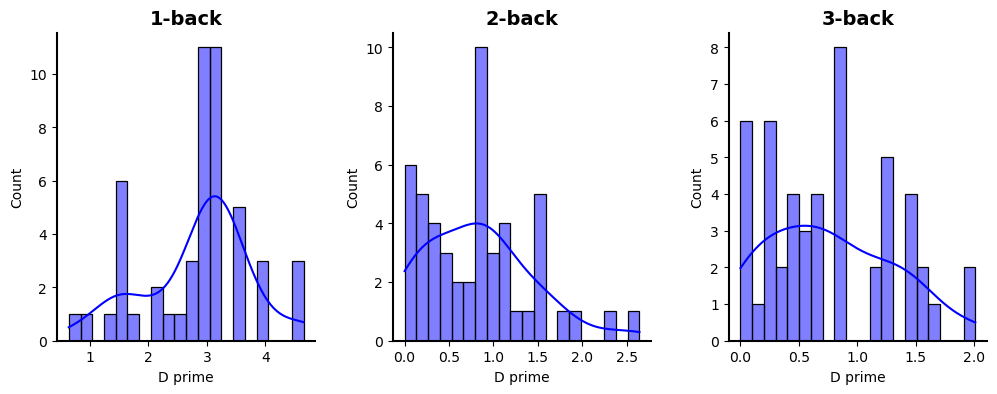

Distribution plot for d_prime:


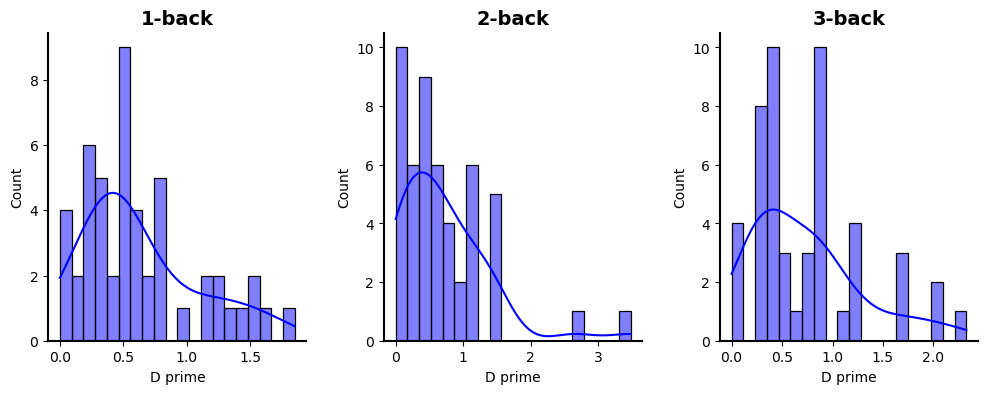

Distribution plot for d_prime:


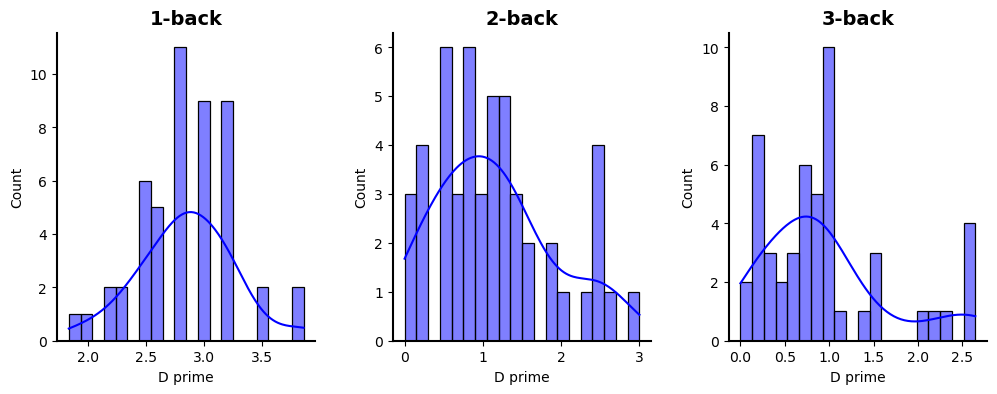

Distribution plot for d_prime:


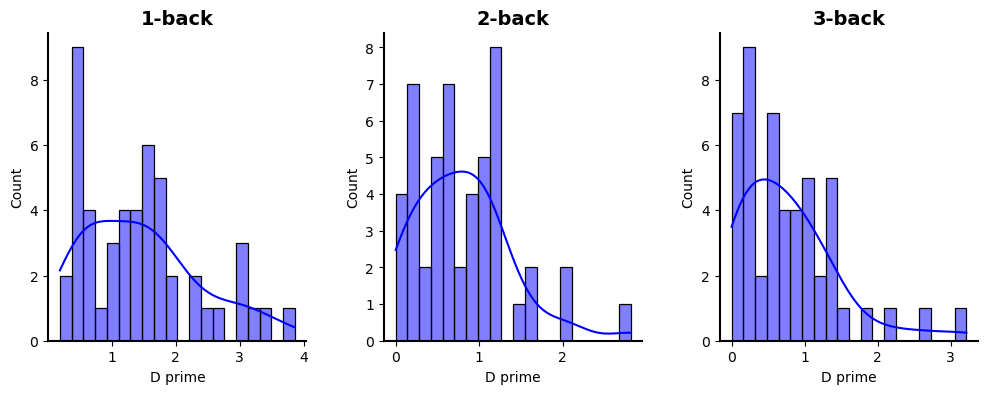

In [73]:
# plot the distribution of the d_prime scores for each N-back level for the spatial task experiments
task_names = ["Spatial", "Spatial with Noise", "Spatial with CoT Reasoning", "Spatial with Feedback"]
for i,exp_name in enumerate(exps):
    fig = plot_distribution(raw_data_spatial_exps[exp_name], n_list)
    fig.savefig(os.path.join("figures", "distribution{}.pdf".format(task_names[i])), format="pdf", dpi=300, bbox_inches='tight')

loading data from all_trials_spatial_3*3.json
loading data from all_trials_spatial_4*4.json
loading data from all_trials_spatial_5*5.json
loading data from all_trials_spatial_7*7.json


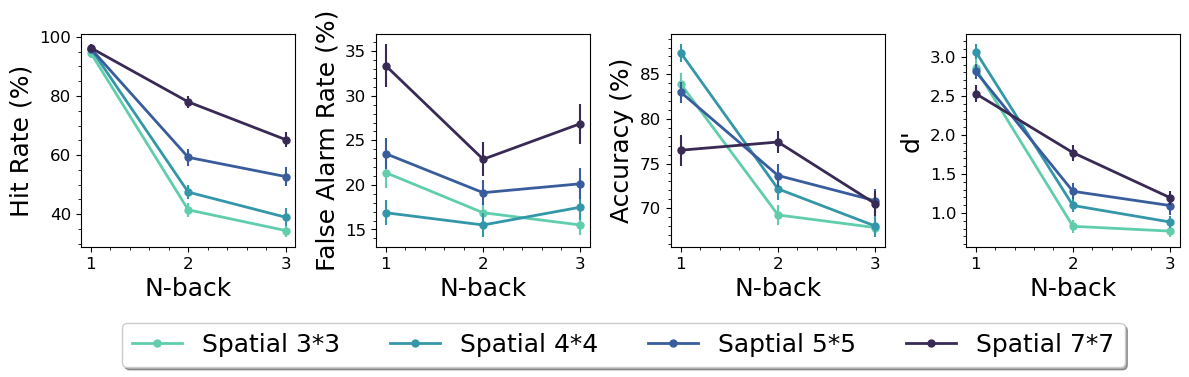

In [74]:
exps = ['all_trials_spatial_3*3.json', 'all_trials_spatial_4*4.json', 'all_trials_spatial_5*5.json', 'all_trials_spatial_7*7.json']
spatial_exps_grid = load_data_from_experiments(exps)

# compute summary statistics for the spatial task experiments
summary_stats_spatial_exps_grid = {}
raw_data_spatial_exps_grid = {}
for exp_name in exps:
    summary_stats_spatial_exps_grid[exp_name],raw_data_spatial_exps_grid[exp_name] = compute_summary_stats(spatial_exps_grid[exp_name], exp_name, n_list, blocks)

# plot performance for the spatial task experiments

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
axes = axes.flatten()
palette = sns.color_palette("mako_r", 4)
line_styles = ['-', '-', '-', '-']

for i, (measure, ylabel) in enumerate(zip(["hit_rate", "false_alarm_rate", "accuracy", "d_prime"],
                                            ["Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "d'"])):
    ax = axes[i]
    for j, (summary_stats, label) in enumerate(zip([summary_stats_spatial_exps_grid[exp] for exp in exps],
                                    ["Spatial 3*3", "Spatial 4*4", "Saptial 5*5", "Spatial 7*7"])):
        ax.plot(n_list, [summary_stats[n][measure]["mean"] for n in n_list], label=label,  color=palette[j], linestyle=line_styles[j], linewidth=2,marker='o', markersize=5)
        ax.errorbar(n_list, [summary_stats[n][measure]["mean"] for n in n_list],
                    yerr=[summary_stats[n][measure]["stderr"] for n in n_list], fmt='none',  ecolor=palette[j], alpha=1)

    ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xlabel("N-back", fontsize=18)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.3), fancybox=True, shadow=True, ncol=4, fontsize=18)
plt.show()

# save figure
fig.savefig(os.path.join("figures", "performance_on_spatial_n_back_tasks_2.pdf"), format="pdf", dpi=300, bbox_inches='tight')

In [75]:
# for each of the spatial task above, perform non-parametric statistical tests (Kruskal-Wallis H test and post-hoc U test) on the d_prime scores across different N-back levels
# and define a function to create a latex table for the H tests
# and define a function to create a latex table for the post hoc U tests

H_results = []
U_results = []

for i,exp_name in enumerate(exps):
    H_result, U_result = nonparametric_test(raw_data_spatial_exps_grid[exp_name], n_list)
    U_results.append(U_result)
    H_results.append(H_result)

task_names = ["Spatial 3*3", "Spatial 4*4", "Saptial 5*5", "Spatial 7*7"]

# put the H test results of all the verbal tasks together and create a latex table
def create_table_H(results, task_names):
    headers = ["Task", "H", "p", "$\epsilon^2$"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        row = [task_name]
        for i,header in enumerate(headers[1:]):
            row.append(result[i])
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_H(H_results, task_names)

# we need to define another column for the U test names within each task
test_groups = ["1-back vs 2-back","1-back vs 3-back","2-back vs 3-back"]
# each U result is a tuple of 3 lists, each list contains the U test results for one of the test groups
# put the U test results of all the verbal tasks together and create a latex table
# each row should be the U test results (including "U","Bonferroni-corrected p","rank-biserial correlation(r)") for one of the test groups
def create_table_U(results, task_names,test_groups):
    headers = ["Task", "Test","U","Bonferroni-corrected p","rank-biserial correlation(r)"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_U(U_results, task_names,test_groups)



\begin{tabular}{lrrr}
\hline
 Task        &       H &           p &   $\epsilon^2$ \\
\hline
 Spatial 3*3 & 84.9206 & 3.62842e-19 &       0.564086 \\
 Spatial 4*4 & 93.9609 & 3.95043e-21 &       0.625585 \\
 Saptial 5*5 & 73.0433 & 1.37675e-16 &       0.483288 \\
 Spatial 7*7 & 53.6315 & 2.25977e-12 &       0.351235 \\
\hline
\end{tabular}
\begin{tabular}{llrrr}
\hline
 Task        & Test             &      U &   Bonferroni-corrected p &   rank-biserial correlation(r) \\
\hline
 Spatial 3*3 & 1-back vs 2-back & 2392   &              9.56099e-15 &                        -0.9136 \\
 Spatial 3*3 & 1-back vs 3-back & 2415.5 &              2.57312e-15 &                        -0.9324 \\
 Spatial 3*3 & 2-back vs 3-back & 1310   &              1           &                        -0.048  \\
 Spatial 4*4 & 1-back vs 2-back & 2442.5 &              5.49518e-16 &                        -0.954  \\
 Spatial 4*4 & 1-back vs 3-back & 2470.5 &              1.07401e-16 &                        -0.9764 

In [76]:
# create dprime Wilcoxon test table

dprime_results = []

for i,exp_name in enumerate(exps):
    result = test_dprime(raw_data_spatial_exps_grid[exp_name], n_list)
    dprime_results.append(result)

task_names = ["Spatial 3*3", "Spatial 4*4", "Saptial 5*5", "Spatial 7*7"]
test_groups = ["1-back","2-back","3-back"]

def create_table_dprime(results, task_names,test_groups):
    headers = ["Task","n-back","T","p","r"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_dprime(dprime_results, task_names,test_groups)
    




\begin{tabular}{llrrr}
\hline
 Task        & n-back   &    T &           p &          r \\
\hline
 Spatial 3*3 & 1-back   & 1271 & 6.21725e-15 &  0.993725  \\
 Spatial 3*3 & 2-back   &  409 & 0.986917    & -0.358431  \\
 Spatial 3*3 & 3-back   &  374 & 0.995018    & -0.413333  \\
 Spatial 4*4 & 1-back   & 1275 & 8.88178e-16 &  1         \\
 Spatial 4*4 & 2-back   &  721 & 0.213148    &  0.13098   \\
 Spatial 4*4 & 3-back   &  506 & 0.897762    & -0.206275  \\
 Saptial 5*5 & 1-back   & 1274 & 1.77636e-15 &  0.998431  \\
 Saptial 5*5 & 2-back   &  856 & 0.0172654   &  0.342745  \\
 Saptial 5*5 & 3-back   &  652 & 0.446724    &  0.0227451 \\
 Spatial 7*7 & 1-back   & 1267 & 2.22045e-14 &  0.987451  \\
 Spatial 7*7 & 2-back   & 1208 & 1.94099e-10 &  0.894902  \\
 Spatial 7*7 & 3-back   &  821 & 0.038598    &  0.287843  \\
\hline
\end{tabular}


Distribution plot for d_prime:


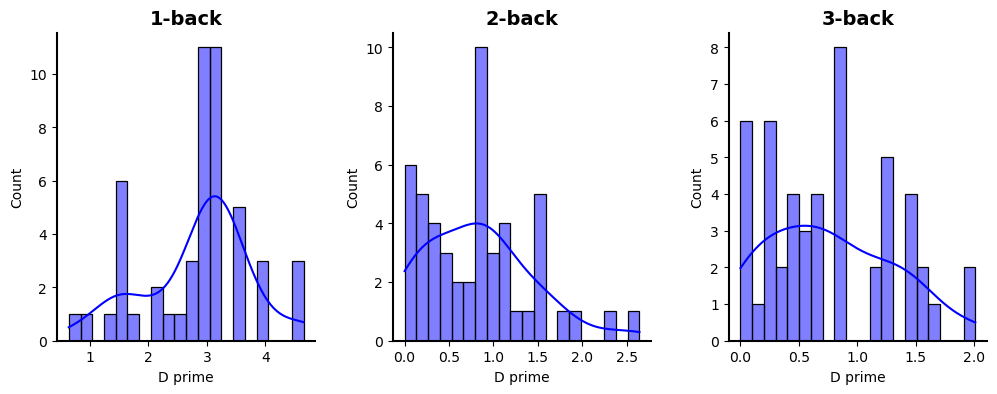

Distribution plot for d_prime:


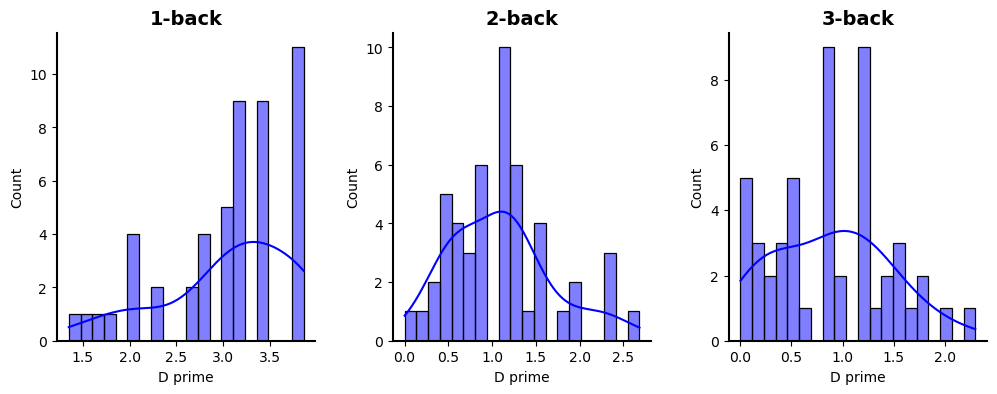

Distribution plot for d_prime:


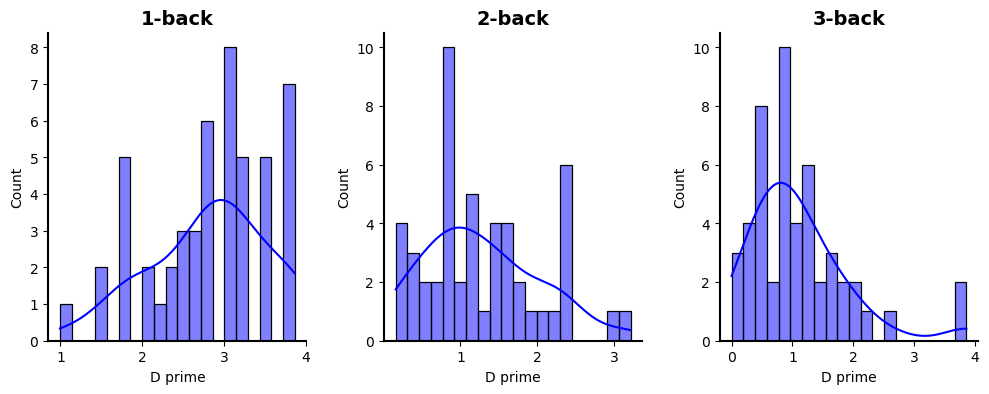

Distribution plot for d_prime:


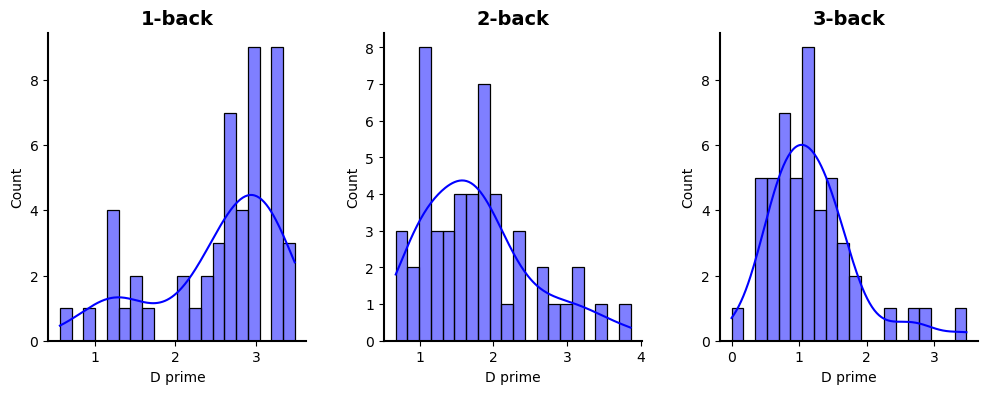

In [77]:
# plot the distribution of the d_prime scores for each N-back level for the spatial task experiments
task_names = ["Spatial 3*3", "Spatial 4*4", "Saptial 5*5", "Spatial 7*7"]
for i,exp_name in enumerate(exps):
    fig = plot_distribution(raw_data_spatial_exps_grid[exp_name], n_list)
    fig.savefig(os.path.join("figures", "distribution{}.pdf".format(task_names[i])), format="pdf", dpi=300, bbox_inches='tight')

loading data from all_trials_spatial_3*3.json
loading data from all_trials_spatial_abstraction.json
loading data from all_trials_spatial_abstraction_2.json


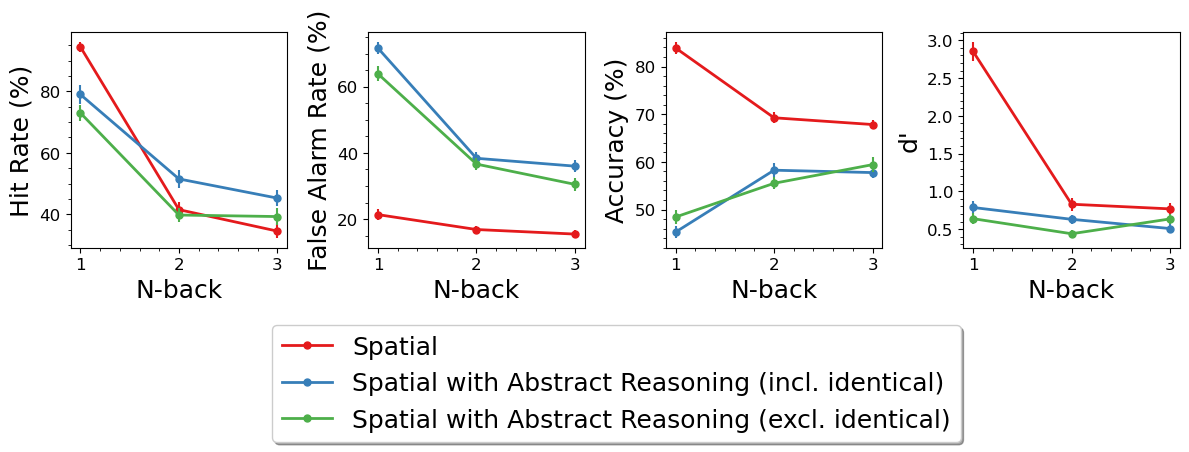

In [78]:
exps = ['all_trials_spatial_3*3.json', 'all_trials_spatial_abstraction.json', 'all_trials_spatial_abstraction_2.json']
spatial_exps_abstraction = load_data_from_experiments(exps)

# compute summary statistics for the spatial task experiments
summary_stats_spatial_exps_abstraction = {}
raw_data_spatial_exps_abstraction = {}
for exp_name in exps:
    summary_stats_spatial_exps_abstraction[exp_name],raw_data_spatial_exps_abstraction[exp_name] = compute_summary_stats(spatial_exps_abstraction[exp_name], exp_name, n_list, blocks)

# plot performance for the spatial task experiments
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
axes = axes.flatten()
palette = sns.color_palette("Set1", 3)
line_styles = ['-', '-', '-', '-']

for i, (measure, ylabel) in enumerate(zip(["hit_rate", "false_alarm_rate", "accuracy", "d_prime"],
                                            ["Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "d'"])):
    ax = axes[i]
    for j, (summary_stats, label) in enumerate(zip([summary_stats_spatial_exps_abstraction[exp] for exp in exps],
                                    ["Spatial", "Spatial with Abstract Reasoning (incl. identical)", "Spatial with Abstract Reasoning (excl. identical)"])):
        
        ax.plot(n_list, [summary_stats[n][measure]["mean"] for n in n_list], label=label,  color=palette[j], linestyle=line_styles[j], linewidth=2,marker='o', markersize=5)
        ax.errorbar(n_list, [summary_stats[n][measure]["mean"] for n in n_list],
                    yerr=[summary_stats[n][measure]["stderr"] for n in n_list], fmt='none',  ecolor=palette[j], alpha=1)

    ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xlabel("N-back", fontsize=18)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.3), fancybox=True, shadow=True, ncol=1, fontsize=18)
plt.show()

# save figure
fig.savefig(os.path.join("figures", "performance_on_spatial_n_back_tasks_3.pdf"), format="pdf", dpi=300, bbox_inches='tight')

In [79]:
# for each of the spatial task above, perform non-parametric statistical tests (Kruskal-Wallis H test and post-hoc U test) on the d_prime scores across different N-back levels
# and define a function to create a latex table for the H tests
# and define a function to create a latex table for the post hoc U tests

H_results = []
U_results = []

for i,exp_name in enumerate(exps):
    H_result, U_result = nonparametric_test(raw_data_spatial_exps_abstraction[exp_name], n_list)
    U_results.append(U_result)
    H_results.append(H_result)

task_names = ["Spatial", "Spatial with Abstract Reasoning (incl. identical)", "Spatial with Abstract Reasoning (excl. identical)"]

# put the H test results of all the verbal tasks together and create a latex table
def create_table_H(results, task_names):
    headers = ["Task", "H", "p", "$\epsilon^2$"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        row = [task_name]
        for i,header in enumerate(headers[1:]):
            row.append(result[i])
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_H(H_results, task_names)

# we need to define another column for the U test names within each task
test_groups = ["1-back vs 2-back","1-back vs 3-back","2-back vs 3-back"]
# each U result is a tuple of 3 lists, each list contains the U test results for one of the test groups
# put the U test results of all the verbal tasks together and create a latex table
# each row should be the U test results (including "U","Bonferroni-corrected p","rank-biserial correlation(r)") for one of the test groups
def create_table_U(results, task_names,test_groups):
    headers = ["Task", "Test","U","Bonferroni-corrected p","rank-biserial correlation(r)"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_U(U_results, task_names,test_groups)



\begin{tabular}{lrrr}
\hline
 Task                                              &        H &           p &   $\epsilon^2$ \\
\hline
 Spatial                                           & 84.9206  & 3.62842e-19 &      0.564086  \\
 Spatial with Abstract Reasoning (incl. identical) &  4.06941 & 0.130719    &      0.0140776 \\
 Spatial with Abstract Reasoning (excl. identical) &  7.19739 & 0.0273595   &      0.0353564 \\
\hline
\end{tabular}
\begin{tabular}{llrrr}
\hline
 Task                                              & Test             &      U &   Bonferroni-corrected p &   rank-biserial correlation(r) \\
\hline
 Spatial                                           & 1-back vs 2-back & 2392   &              9.56099e-15 &                        -0.9136 \\
 Spatial                                           & 1-back vs 3-back & 2415.5 &              2.57312e-15 &                        -0.9324 \\
 Spatial                                           & 2-back vs 3-back & 1310   &              1 

In [80]:
# create dprime Wilcoxon test table

dprime_results = []

for i,exp_name in enumerate(exps):
    result = test_dprime(raw_data_spatial_exps_abstraction[exp_name], n_list)
    dprime_results.append(result)

task_names = ["Spatial", "Spatial with Abstract Reasoning (incl. identical)", "Spatial with Abstract Reasoning (excl. identical)"]
test_groups = ["1-back","2-back","3-back"]

def create_table_dprime(results, task_names,test_groups):
    headers = ["Task","n-back","T","p","r"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_dprime(dprime_results, task_names,test_groups)
    




\begin{tabular}{llrrr}
\hline
 Task                                              & n-back   &    T &           p &         r \\
\hline
 Spatial                                           & 1-back   & 1271 & 6.21725e-15 &  0.993725 \\
 Spatial                                           & 2-back   &  409 & 0.986917    & -0.358431 \\
 Spatial                                           & 3-back   &  374 & 0.995018    & -0.413333 \\
 Spatial with Abstract Reasoning (incl. identical) & 1-back   &  408 & 0.98725     & -0.36     \\
 Spatial with Abstract Reasoning (incl. identical) & 2-back   &  152 & 1           & -0.761569 \\
 Spatial with Abstract Reasoning (incl. identical) & 3-back   &   65 & 1           & -0.898039 \\
 Spatial with Abstract Reasoning (excl. identical) & 1-back   &  191 & 0.999998    & -0.700392 \\
 Spatial with Abstract Reasoning (excl. identical) & 2-back   &   54 & 1           & -0.915294 \\
 Spatial with Abstract Reasoning (excl. identical) & 3-back   &  150 & 1         

Distribution plot for d_prime:


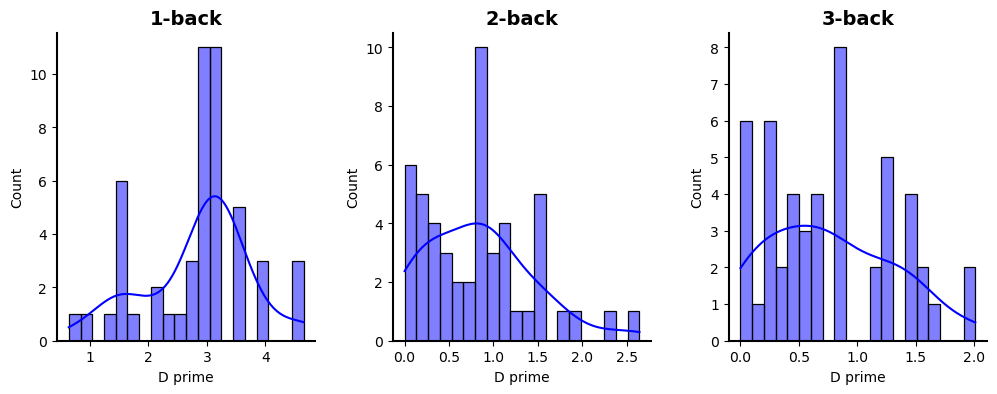

Distribution plot for d_prime:


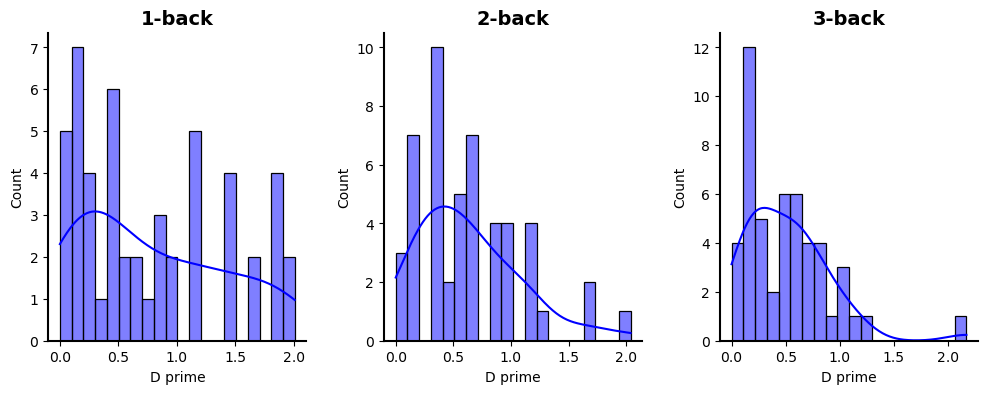

Distribution plot for d_prime:


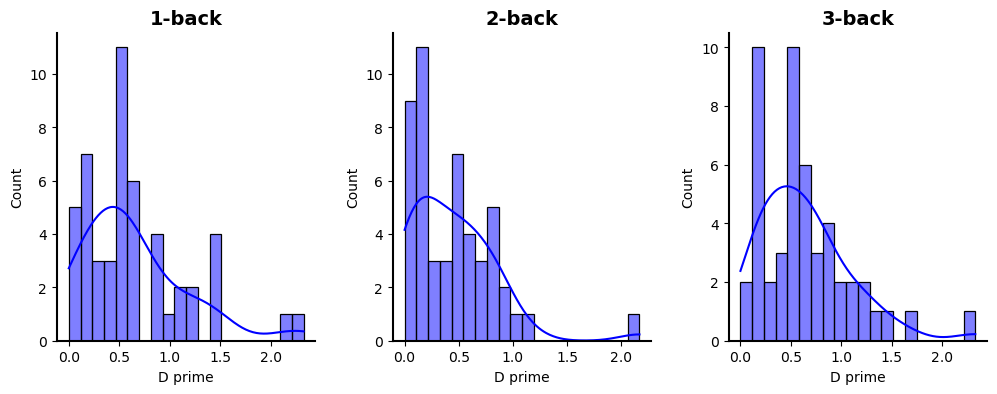

In [81]:
# plot the distribution of the d_prime scores for each N-back level for the spatial task experiments
task_names = ["Spatial", "Spatial with Abstract Reasoning (including identical locations)", "Spatial with Abstract Reasoning (excluding identical locations)"]
for i,exp_name in enumerate(exps):
    fig = plot_distribution(raw_data_spatial_exps_abstraction[exp_name], n_list)
    fig.savefig(os.path.join("figures", "distribution{}.pdf".format(task_names[i])), format="pdf", dpi=300, bbox_inches='tight')

loading data from all_trials_verbal_bloomz-7b.json
loading data from all_trials_verbal_bloomz-7b1-mt.json
loading data from all_trials_verbal_chatglm-6b_v1.0.json
loading data from all_trials_verbal_chatglm-6b_v1.1.json
loading data from all_trials_verbal.json
loading data from all_trials_verbal_gpt-4.json
loading data from all_trials_verbal_Vicuna-7B.json
loading data from all_trials_verbal_Vicuna-13B.json


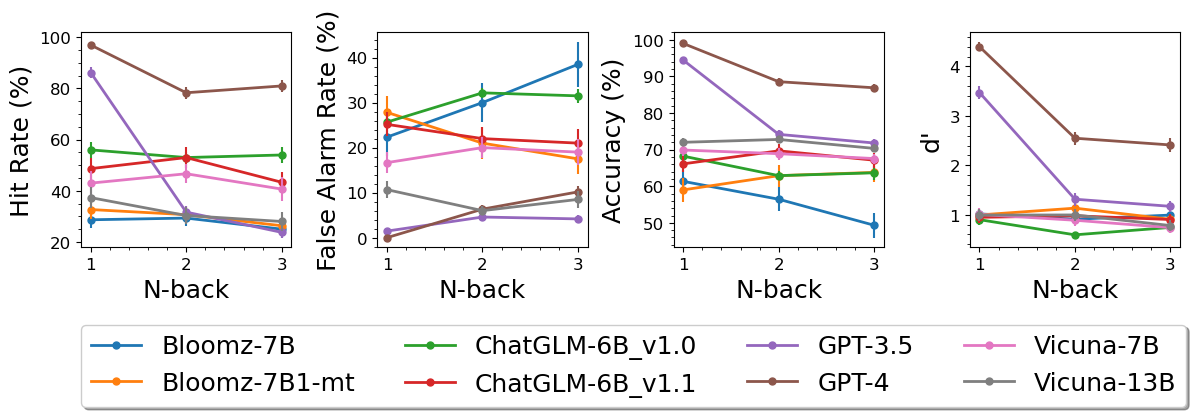

In [82]:
exps = ['all_trials_verbal_bloomz-7b.json','all_trials_verbal_bloomz-7b1-mt.json','all_trials_verbal_chatglm-6b_v1.0.json','all_trials_verbal_chatglm-6b_v1.1.json','all_trials_verbal.json','all_trials_verbal_gpt-4.json','all_trials_verbal_Vicuna-7B.json','all_trials_verbal_Vicuna-13B.json']
blocks = 30 # changed to 30 to shorten the time
verbal_exps = load_data_from_experiments(exps)

# compute summary statistics for the experiments
summary_stats_exps = {}
raw_data_exps = {}
for exp_name in exps:
    summary_stats_exps[exp_name],raw_data_exps[exp_name] = compute_summary_stats(verbal_exps[exp_name], exp_name, n_list, blocks)

# plot performance for the experiments
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True)
axes = axes.flatten()
palette = sns.color_palette()
line_styles = ['-', '-', '-', '-', '-', '-', '-', '-']

for i, (measure, ylabel) in enumerate(zip(["hit_rate", "false_alarm_rate", "accuracy", "d_prime"],
                                            ["Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "d'"])):
    ax = axes[i]
    for j, (summary_stats, label) in enumerate(zip([summary_stats_exps[exp] for exp in exps],
                                    ["Bloomz-7B", "Bloomz-7B1-mt", "ChatGLM-6B_v1.0", "ChatGLM-6B_v1.1", "GPT-3.5", "GPT-4", "Vicuna-7B", "Vicuna-13B"])):
        
        ax.plot(n_list, [summary_stats[n][measure]["mean"] for n in n_list], label=label,  color=palette[j], linestyle=line_styles[j], linewidth=2,marker='o', markersize=5)
        ax.errorbar(n_list, [summary_stats[n][measure]["mean"] for n in n_list],
                    yerr=[summary_stats[n][measure]["stderr"] for n in n_list], fmt='none',  ecolor=palette[j], alpha=1)

    ax.set_ylabel(ylabel, fontsize=18)
    ax.grid(False)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xlabel("N-back", fontsize=18)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-1.6, -0.3), fancybox=True, shadow=True, ncol=4, fontsize=18)
plt.show()

# save figure
fig.savefig(os.path.join("figures", "performance_on_verbal_all_models.pdf"), format="pdf", dpi=300, bbox_inches='tight')

In [83]:
# for each of the spatial task above (["Spatial", "Spatial with Noise", "Spatial with CoT Reasoning", "Spatial with Feedback"]), perform non-parametric statistical tests (Kruskal-Wallis H test and post-hoc U test) on the d_prime scores across different N-back levels
# and define a function to create a latex table for the H tests
# and define a function to create a latex table for the post hoc U tests

H_results = []
U_results = []

for i,exp_name in enumerate(exps):
    H_result, U_result = nonparametric_test(raw_data_exps[exp_name], n_list)
    U_results.append(U_result)
    H_results.append(H_result)

task_names = ["Bloomz-7B", "Bloomz-7B1-mt", "ChatGLM-6B_v1.0", "ChatGLM-6B_v1.1", "GPT-3.5", "GPT-4", "Vicuna-7B", "Vicuna-13B"]

# put the H test results of all the verbal tasks together and create a latex table
def create_table_H(results, task_names):
    headers = ["Model", "H", "p", "$\epsilon^2$"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        row = [task_name]
        for i,header in enumerate(headers[1:]):
            row.append(result[i])
        table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_H(H_results, task_names)

# we need to define another column for the U test names within each task
test_groups = ["1-back vs 2-back","1-back vs 3-back","2-back vs 3-back"]
# each U result is a tuple of 3 lists, each list contains the U test results for one of the test groups
# put the U test results of all the verbal tasks together and create a latex table
# each row should be the U test results (including "U","Bonferroni-corrected p","rank-biserial correlation(r)") for one of the test groups
def create_table_U(results, task_names,test_groups):
    headers = ["Model", "Test","U","Bonferroni-corrected p","rank-biserial correlation(r)"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_U(U_results, task_names,test_groups)



\begin{tabular}{lrrr}
\hline
 Model           &          H &           p &   $\epsilon^2$ \\
\hline
 Bloomz-7B       &  0.729608  & 0.694333    &   -0.0146022   \\
 Bloomz-7B1-mt   &  2.24773   & 0.325021    &    0.00284745  \\
 ChatGLM-6B_v1.0 &  4.14489   & 0.125878    &    0.0246539   \\
 ChatGLM-6B_v1.1 &  0.0159079 & 0.992078    &   -0.0228057   \\
 GPT-3.5         & 58.5421    & 1.93972e-13 &    0.64991     \\
 GPT-4           & 52.5136    & 3.95191e-12 &    0.580617    \\
 Vicuna-7B       &  2.68935   & 0.260624    &    0.00792362  \\
 Vicuna-13B      &  1.97187   & 0.37309     &   -0.000323345 \\
\hline
\end{tabular}
\begin{tabular}{llrrr}
\hline
 Model           & Test             &     U &   Bonferroni-corrected p &   rank-biserial correlation(r) \\
\hline
 Bloomz-7B       & 1-back vs 2-back & 507   &              1           &                    -0.126667   \\
 Bloomz-7B       & 1-back vs 3-back & 485.5 &              1           &                    -0.0788889  \\
 Bloomz-7

In [84]:
# create dprime Wilcoxon test table

dprime_results = []

for i,exp_name in enumerate(exps):
    result = test_dprime(raw_data_exps[exp_name], n_list)
    dprime_results.append(result)

task_names = ["Bloomz-7B", "Bloomz-7B1-mt", "ChatGLM-6B_v1.0", "ChatGLM-6B_v1.1", "GPT-3.5", "GPT-4", "Vicuna-7B", "Vicuna-13B"]
test_groups = ["1-back","2-back","3-back"]

def create_table_dprime(results, task_names,test_groups):
    headers = ["Model","n-back","T","p","r"]
    table = []
    for (result, task_name) in (zip(results, task_names)):
        for i,test_group in enumerate(test_groups):
            row = [task_name, test_group]
            for j,header in enumerate(headers[2:]):
                row.append(result[j][i])
            table.append(row)

    print(tabulate(table, headers=headers, tablefmt="latex_raw"))

create_table_dprime(dprime_results, task_names,test_groups)
    




\begin{tabular}{llrrr}
\hline
 Model           & n-back   &   T &           p &           r \\
\hline
 Bloomz-7B       & 1-back   & 240 & 0.443597    &  0.0322581  \\
 Bloomz-7B       & 2-back   & 185 & 0.835765    & -0.204301   \\
 Bloomz-7B       & 3-back   & 218 & 0.619467    & -0.0623656  \\
 Bloomz-7B1-mt   & 1-back   & 209 & 0.686827    & -0.101075   \\
 Bloomz-7B1-mt   & 2-back   & 287 & 0.135503    &  0.234409   \\
 Bloomz-7B1-mt   & 3-back   & 181 & 0.855317    & -0.221505   \\
 ChatGLM-6B_v1.0 & 1-back   & 168 & 0.908015    & -0.277419   \\
 ChatGLM-6B_v1.0 & 2-back   &  21 & 1           & -0.909677   \\
 ChatGLM-6B_v1.0 & 3-back   & 103 & 0.996903    & -0.556989   \\
 ChatGLM-6B_v1.1 & 1-back   & 199 & 0.755077    & -0.144086   \\
 ChatGLM-6B_v1.1 & 2-back   & 219 & 0.611716    & -0.0580645  \\
 ChatGLM-6B_v1.1 & 3-back   & 176 & 0.877527    & -0.243011   \\
 GPT-3.5         & 1-back   & 465 & 9.31323e-10 &  1          \\
 GPT-3.5         & 2-back   & 351 & 0.00683162  &  0.

all_trials_verbal_bloomz-7b.json
Distribution plot for d_prime:


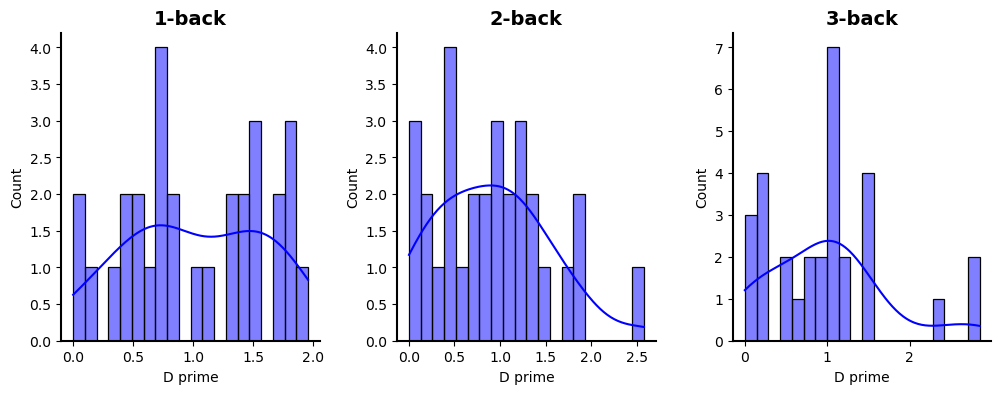

all_trials_verbal_bloomz-7b1-mt.json
Distribution plot for d_prime:


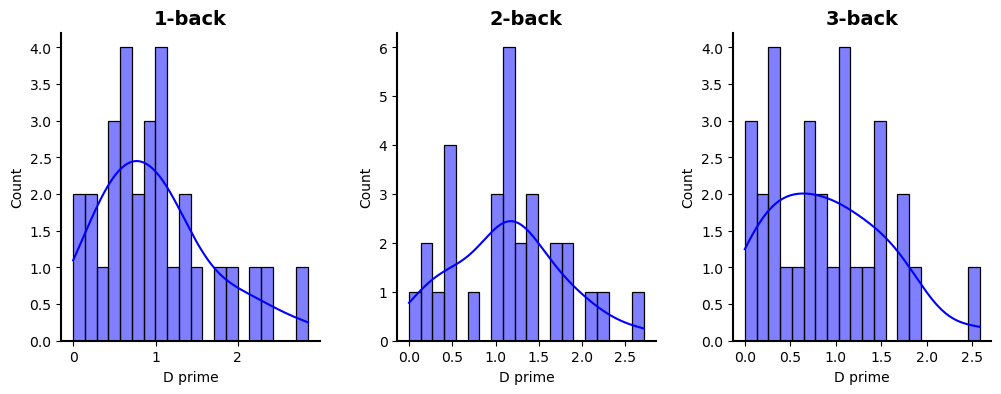

all_trials_verbal_chatglm-6b_v1.0.json
Distribution plot for d_prime:


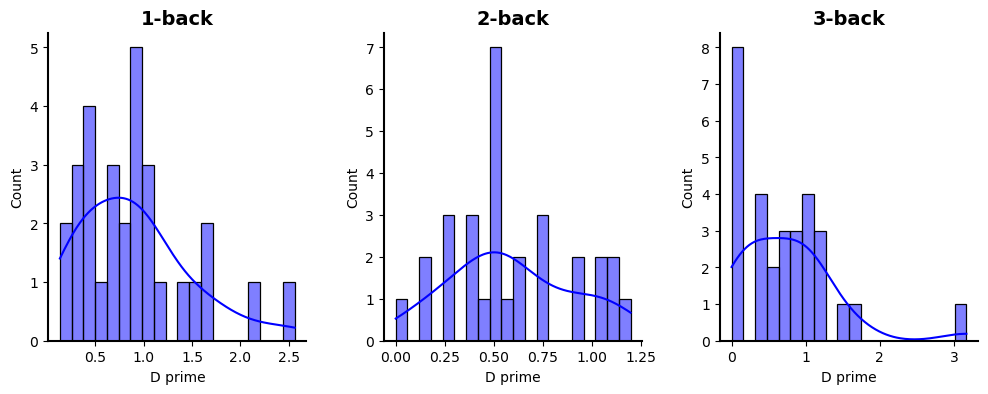

all_trials_verbal_chatglm-6b_v1.1.json
Distribution plot for d_prime:


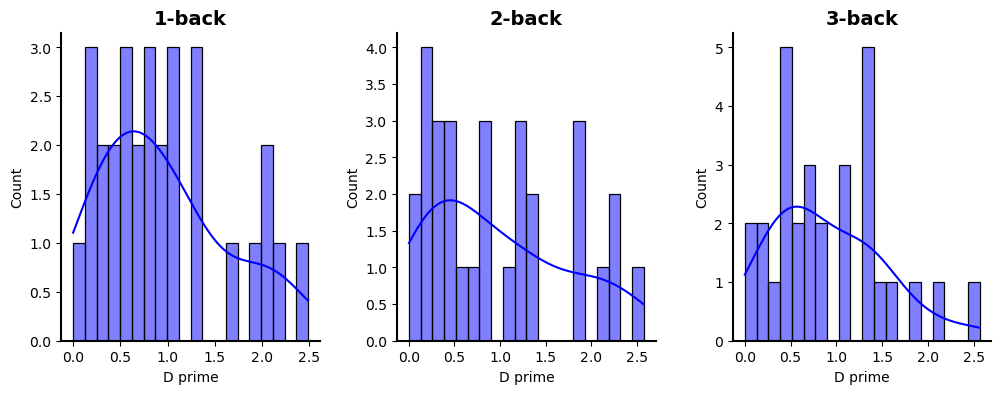

all_trials_verbal.json
Distribution plot for d_prime:


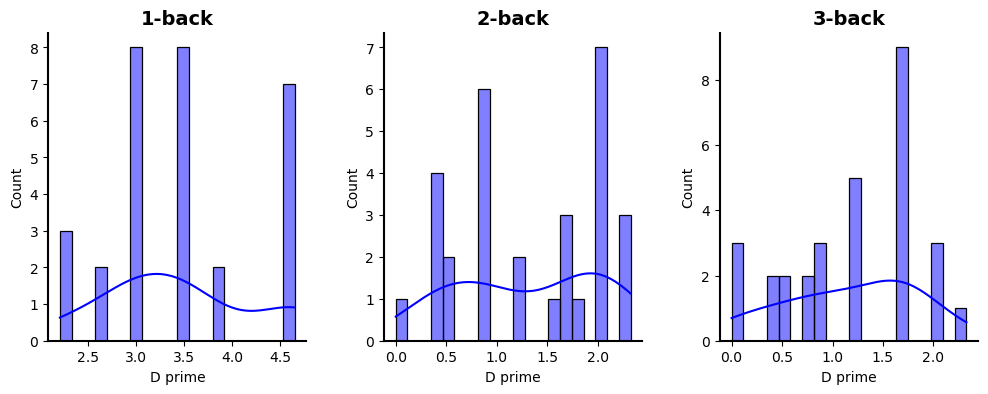

all_trials_verbal_gpt-4.json
Distribution plot for d_prime:


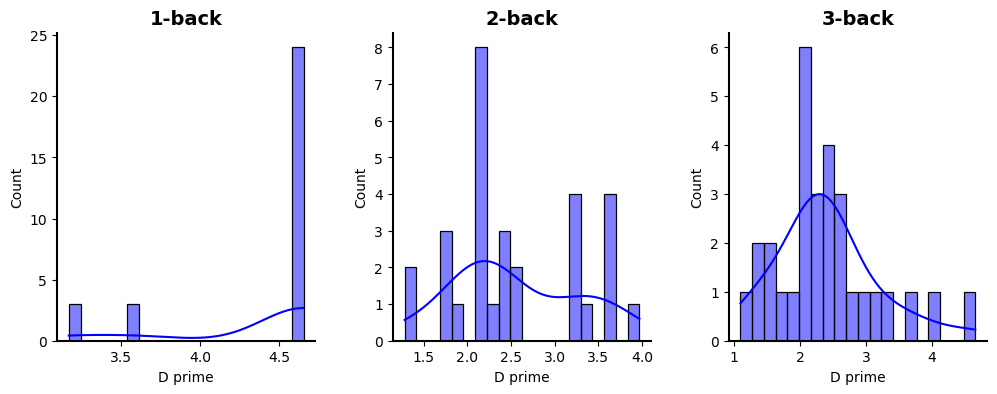

all_trials_verbal_Vicuna-7B.json
Distribution plot for d_prime:


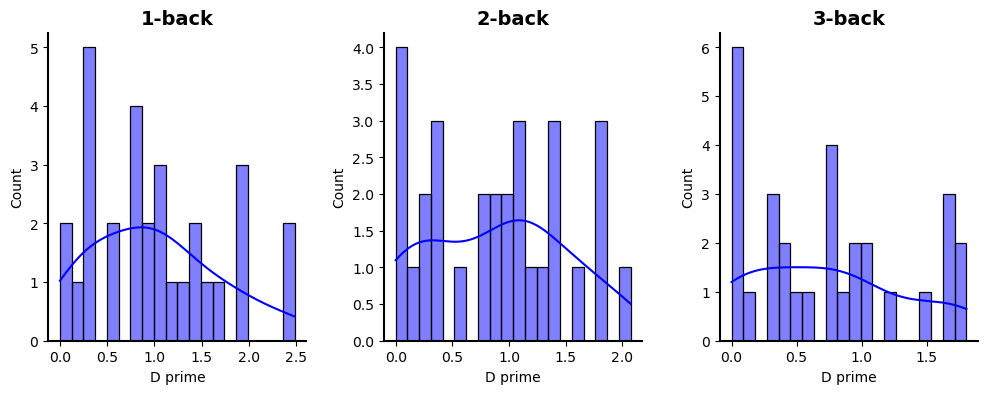

all_trials_verbal_Vicuna-13B.json
Distribution plot for d_prime:


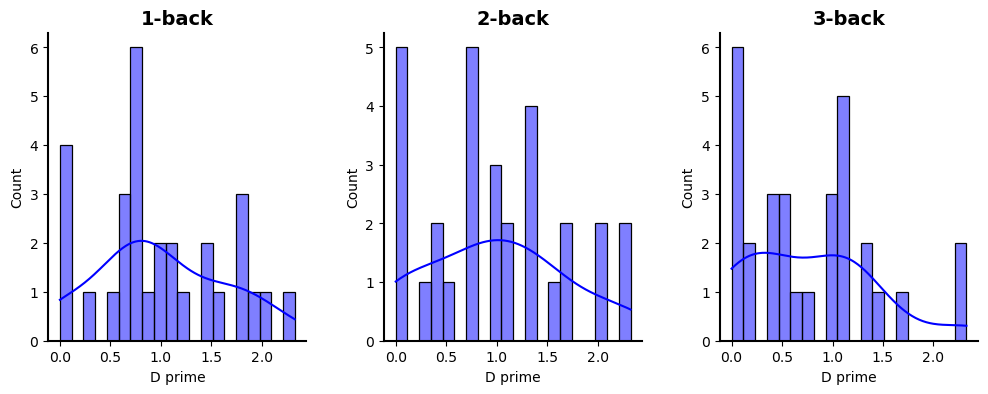

In [85]:
# plot the distribution of the d_prime scores for each N-back level for the spatial task experiments
task_names = ["Bloomz-7B", "Bloomz-7B1-mt", "ChatGLM-6B_v1.0", "ChatGLM-6B_v1.1", "GPT-3.5", "GPT-4", "Vicuna-7B", "Vicuna-13B"]
for i,exp_name in enumerate(exps):
    print(exp_name)
    fig = plot_distribution(raw_data_exps[exp_name], n_list)
    fig.savefig(os.path.join("figures", "distribution_{}.pdf".format(task_names[i])), format="pdf", dpi=300, bbox_inches='tight')